# Evaluate Predictions

The Titanic challenge on Kaggle is based on accuracy, simply number of currect Survived predictions divided by the total number of predictions.

## Predicting Survival 

Some of the models (tree based classifiers, for example) may output the prediction immediately (0 or 1). For those models, call XXX method and get back the stats. 

## Predicting Probabilities

But the more nuanced approach is when a model outputs a probability. IE, we might judge that a passenger had an estimated 79% chance of survival. Because the Kaggle competition requires a 0 or 1 response, we're in charge of picking a cutoff when making our predictions (IE, we'll say anyone with more than 60% probability of surviving did in-fact survive). 

So, in this notebook, we'll define a function that takes as input a series of predicted probabilities, as well as the actual values. It'll loop through thresholds looking for the highest accuracy (in increments of 1%), then return the threshold and best accuracy score. 

...but accuracy can be a shitty way to evaluate a model. For this specific problem, only 706 of 2223 passengers survived, making a 31.7% survival rate. Thus, if we simply predict that each passenger died, we have a model with accuracy rate of 68.3%. 

### ROC Curve

A better way of evaluating a model's predicted probabilities is a Receiver Operating Characteristic (ROC) curve. An ROC curve starts out with a threshold of greater than 100%, (meaning we never say a single data point survived), meaning the True Positive Rate (TPR) is 0%. But! The False Positive Rate (FPR) is also 0. IE, we've made zero guesses, gotten zero correct, but also haven't gotten any wrong. 

ROC Curves are plotted on an XY graph, with TPR on the y-axis and FPR on the x-axis. So the center (origin) at (0,0) represents 0% correct, 0% incorrect. ''As an aside, this isn't useful, but sets up the chart''. 

Next, we decrease the threshold to 100% (meaning, only guess survival for passengers our model gave a 100% probability of surviving). Let's say our model had 10 passengers with 100% probability, and one was wrong (they actually died). The next point on our ROC curve would be (.1, .9) - we were correct for 90% of our guesses, wrong on 10%. 

To complete the ROC curve, just keep decreasing the threshold and plot the (FPR, TPR). Eventually, you'll plot a threshold where you start guessing incorrectly more. It usually looks something like: 

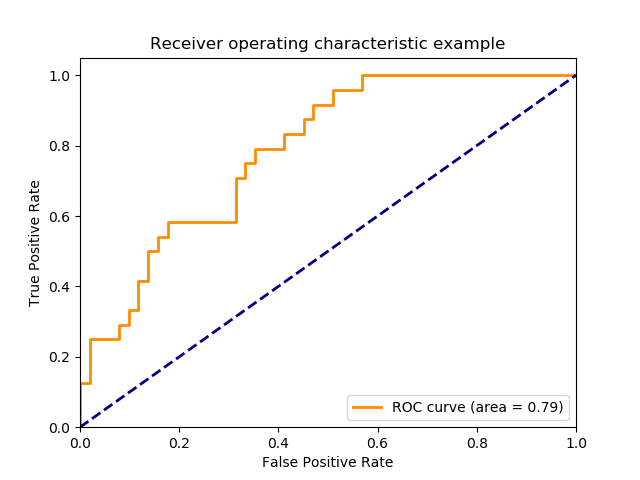


The worst possible model (one that gets every answer wrong) would just be a straight line across the bottom of the graph (Ironically, this would make a perfect model, too, since you could just ask the model for it's guess, then guess the opposite). 

A random model (just guess randomly) would be a straight diagonal line from (0,0) to (1,1), meaning your TPR and your FPR are equally likely. 

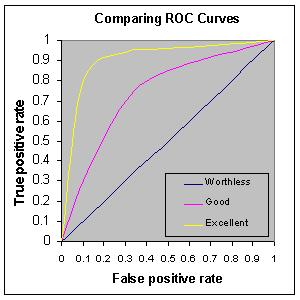

What we're aiming for is shown above in yellow - TPR increases fast, FPR stays tiny. (For more info: http://gim.unmc.edu/dxtests/RoC3.htm)

### Area Under the Curve

All this is to say, we can actually judge how good a model is by measuring the Area Under the Curve (AUC). A perfect model has AUC = 1.0 and a random model should have AUC = 0.5.

So, when we loop through thresholds and find the best accuracy, we'll also print the ROC Curve and return the AUC, just to help us compare models. 

In [3]:
# Import libraries
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Helper function - calculate accuracy 
def calc_accuracy(y_predict, y_true, threshold):
    total = 0 
    correct = 0 
    if len(y_predict.shape) > 1:
        for i, y_t in enumerate(y_true):
            guess = 1 if y_predict[i][0] > threshold else 0
            if y_t == guess:
                correct += 1
            total += 1
    else:
        for i, y_t in enumerate(y_true):
            guess = 1 if y_predict[i] > threshold else 0
            if y_t == guess:
                correct += 1
            total += 1
    return correct/total

In [6]:
def evaluate_predicted_probabilities(y_predict, y_true, print_roc=True):
    '''Evaluate the Predicted Probability of survial

    Given two numpy series, one with predicted probabilities, the other with corresponding 0/1 values for survial, 
    calculate the best accuracy threshold and accuracy, calculate the AUC, and plot the ROC curve.

    Tuple returned is (AUC, Accuracy, best threshold)

    '''
    
    # Calculate best accuracy and threshold 

    best_acc = 0 
    best_threshold = 0

    for i in range(100):
        cur_acc = calc_accuracy(y_predict, y_true, i / 100)
        if cur_acc > best_acc:
            best_acc = cur_acc
            best_threshold = i / 100
    
    # Calculate AUC 
    fpr, tpr, thresholds= roc_curve(y_validate, y_predict)
    roc_auc = auc(fpr, tpr)
    
    if print_roc:
        # Plot the ROC Curve
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()
    
    # Return a tuple with 
    return (roc_auc, best_acc, best_threshold)

In [ ]:
# Main function - call this 